In [1]:
import numpy as np
import json

from scipy.spatial import Delaunay
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import butter,filtfilt # for fft filtering
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

from scipy import interpolate, signal, ndimage
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.cluster import KMeans #, SpectralClustering, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
import networkx as nx

#Sample Period - 5 sec (t) number of 
#Sampling Freq - 30 samples / s , i.e 30 Hz (fs)
#Total Samples - (fs x t) = 150
#Signal Freq = 6 signal / 5 sec = 1.2 Hz
#Nyquist Frequency = 0.5 * fs
#order = Polynomial order of the signal
#cutoff - which part of fs will be removed 
def butter_lowpass_filter(new_u, data, cutoff=0.1, order = 2):
	a, b = new_u[0], new_u[-1]
	timestep = (b - a)/(new_u.shape[0] - 1) # dt of discretization
	fs = 1.0/timestep # frequency of discretization
	nyq = 0.5*fs
	normal_cutoff = cutoff / (nyq * timestep)
	# Get the filter coefficients 
	b, a = butter(order, normal_cutoff, btype='low', analog=False)
	y = filtfilt(b, a, data)#, method="pad", padlen=5
	return y

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area + 1e-15)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst[0]

from matplotlib.pyplot import *
from scipy import interpolate
def find_first_peak(x_fil, y_fil, x0, xmin, xmax, x_mean, time):
	if x_fil[0] > x_fil[-1]:
		x_fil = x_fil[::-1]
		y_fil = y_fil[::-1]
	ind = np.argmax(y_fil) 
	print("max ={} {}".format(x_fil[ind], y_fil[ind]))    
	#choose some points if they are:
	args = (y_fil >= 0.3) & (x_fil <= x_mean)
	x_ripple = x_fil[args]
	y_ripple = y_fil[args]
    
# 	plt.figure()
# 	plt.plot(x_ripple, y_ripple)
# 	plt.show()

	print("sizes of ripple:{} {}".format(x_ripple.shape, y_ripple.shape))

	#find the first peak in a smoothed curve
	peaks, props = find_peaks(y_ripple, prominence=0.001)
	print("peaks, props:", peaks, props)
	try:
		x_peak, y_peak = x_ripple[peaks[0]], y_ripple[peaks[0]]
	except:
		x_peak, y_peak = np.inf, np.inf
	length_x_clip = x_mean - x_peak
	print('x_peak candidates=', x_ripple[peaks], 'y_peak candidates=', y_ripple[peaks])
	print('x_peak', x_peak, 'y_peak=', y_peak)

	# calculate actual min max thickness and averaged min max values of thickness
	args = (x_fil >= x_peak) & (x_fil <= x_mean)
	y_ripple_slice = y_fil[args]
	delta_min = 0.5 - y_ripple_slice.max()
	delta_max = 0.5 - y_ripple_slice.min()
	delta_min_smooth = 0.5 - y_ripple.max()
	delta_max_smooth = 0.5 - y_ripple.min()
	return x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth




def toX(x, y):
    return np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)

def fromX(X):
    return X[:,0], X[:,1]

def PCAsort(x, y):
    # PCA
    xy = toX(x, y)
    pca = PCA(2).fit(xy)
    xypca = pca.transform(xy)
    newx, newy = fromX(xypca)

    #sort
    indexSort = np.argsort(newx)
    return newx[indexSort], newy[indexSort], pca

def interp_data(x, y, N):
    f = interpolate.interp1d(x, y, kind='linear')
    newx = np.linspace(x[0], x[-1], N)
    return newx, f(newx)

def align_data(x, y, direction):
    ddir = np.hstack((x[-1] - x[0], y[-1] - y[0]));
    return (x, y) if np.dot(direction, ddir) > 0 else (x[::-1], y[::-1])


# Solution from https://stackoverflow.com/a/63368162/2531400
def XYclean(x, y, window=None, N=None):
    newx, newy, pca = PCAsort(x, y)

    #add some more points (optional)
    newx, newy = interp_data(newx, newy, N)

    #smooth with a filter (optional)
    newy = signal.savgol_filter(newy, window, 2)

    #return back to old coordinates
    xyclean = pca.inverse_transform(toX(newx, newy))

    return fromX(xyclean)

def smoother_vf(xin, yin, N_polynomials = 20, sigma = 1):
    xin_min = min(xin)
    xin_max = max(xin)
    yin_min = min(yin)
    yin_max = max(yin)
    
    x = (xin - xin_min)/(xin_max - xin_min)
    y = (yin - yin_min)/(yin_max - yin_min)

    x = x.reshape((len(x), 1))
    D = np.hstack([np.cos(2*np.pi*x*i) for i in range(N_polynomials)] + [np.sin(2*np.pi*x*i) for i in range(N_polynomials)])
    w = np.linalg.inv(D.T @ D + sigma*np.eye(2*N_polynomials)) @ D.T @ y
    
    X = np.linspace(min(x), max(x), 1000)

    X = X.reshape((len(X), 1))
    D = np.hstack([np.cos(2*np.pi*X*i)for i in range(N_polynomials)] + [np.sin(2*np.pi*X*i) for i in range(N_polynomials)])
    Y = D @ w
    X = X.reshape((len(X), ))
#     plt.plot(x, y, ".", color="grey", alpha=0.3, label="data")
#     plt.plot(X, Y, color="red", label="fit")
#     plt.legend();
    
    return (X + xin_min)*(xin_max - xin_min), (Y + yin_min)*(yin_max - yin_min)


from tsmoothie.smoother import *

def find_min_max_curve(points, alpha, p0, pN):
    # Computing the alpha shape
    edges = alpha_shape(points, alpha=alpha, only_outer=True)
    #order edges
    edges = stitch_boundaries(edges)
    
    edge_points = np.zeros((len(edges),2))
    k=0
    for i, j in edges:
        edge_points[k,:] = points[[i, j], 0][0] , points[[i, j], 1][0]
        k += 1
    inodes, jnodes = zip(*edges)
    min_x_ind = np.argmin(np.linalg.norm(edge_points - p0,axis=1))
    max_x_ind = np.argmin(np.linalg.norm(edge_points - pN,axis=1))
    print("min_x_ind={} max_x_ind={}".format(min_x_ind, max_x_ind))
#     min_x_ind = np.argmin(edge_points[:, 0])
#     max_x_ind = np.argmax(edge_points[:, 0])
    if min_x_ind < max_x_ind:
        lower_hull = edge_points[min_x_ind:max_x_ind+1, :]
        upper_hull = np.concatenate([edge_points[max_x_ind:, :], edge_points[:min_x_ind+1, :]])
    else:
        upper_hull = edge_points[max_x_ind:min_x_ind+1, :]
        lower_hull = np.concatenate([edge_points[min_x_ind:, :], edge_points[:max_x_ind+1, :]])
    return lower_hull, upper_hull
    

def plot_smoothed_curve(x, y, alpha = 0.1, N = 4000, M = 3, Ninterp = 4000, Npolyfit = 50, savgol_order = 2, window = 100,
                        is_cycle = False, show_in_pca = False, plot_clusters=True, plot_all_points=True, 
                        plot_min_max_curves=True, plot_smooth_curve=True, plot_rhomb = True, show_cluster_num = True, show_split_line=True):
    Npca = N//M
    window += 1 if window % 2 == 0 else 0
    
    xmin = x.min()
    xmax = x.max()
    xcm = 0.5*(xmax + xmin)
    inds = x < xcm
    ind_xy0 = y[inds].argmin()
    xy0 = x[inds][ind_xy0], y[inds][ind_xy0]
#     print('xyo****=', xy0, y[inds])
    inds = x > xcm
    ind_xyN = y[inds].argmin()
    xyN = x[inds][ind_xyN], y[inds][ind_xyN]
    length = xyN[0] - xy0[0]
    print('xy0=', xy0, 'xyN=', xyN, 'length=',length)
    
    wdw = max(window, Npolyfit)
    x = np.concatenate([xy0[0] + length*np.linspace(-0.01, 0, wdw), x, xyN[0] + length*np.linspace(0, 0.01, wdw)])
    y = np.concatenate([xy0[1] - np.linspace(0.1, 0, wdw), y, xyN[1] - np.linspace(0,0.1, wdw)])

    plt.figure(figsize=(10,8))
    if plot_all_points:
        plt.plot(x,y, 'b.', linewidth=2, markersize=0.2)

    #split points into 3 parts
    cut_x1, cut_x2 = xmin + .08*(xmax-xmin), xmin + .7*(xmax-xmin)
    if not show_in_pca and show_split_line:
        plt.axvline(x=cut_x1, color='k', linestyle='-.', lw=1)
        plt.axvline(x=cut_x2, color='k', linestyle='-.', lw=1)
    dcut = 0.05
    xmm = {
        0: (-np.inf, cut_x1),
        1: (cut_x1, cut_x2),
        2: (cut_x2, np.inf),
    }
    ymm = np.min(y) + 0.01*(np.max(y) - np.min(y)) # to cut edges of the fitting curve
    inds = [(x < cut_x1 + dcut*(xmax-xmin)),
            (x > cut_x1 - dcut*(xmax-xmin)) & (x < cut_x2 + dcut*(xmax-xmin)),
            (x >= cut_x2 - dcut*(xmax-xmin))]

    ccenters = np.zeros((M, 2))
    color = plt.cm.rainbow(np.linspace(0, 1, M))
    for i, c in zip(range(M), color):
        x_, y_ = np.asarray(x[inds[i]]), np.asarray(y[inds[i]])
        ccenters[i,:] = x_.mean(), y_.mean()
        if not show_in_pca and plot_clusters:
            plt.scatter(x_, y_, s=1, color=c)
            plt.text(ccenters[i,0]+.03, ccenters[i,1]+.03, i, color=c)
            #plt.plot([np.min(x_)], [np.min(y_)], marker='>', markersize=5, color=c, markeredgecolor='k')
            #plt.plot([np.min(x_)], [np.max(y_)], marker='>', markersize=5, color=c, markeredgecolor='k')
            #plt.plot([np.max(x_)], [np.min(y_)], marker='<', markersize=5, color=c, markeredgecolor='k')
            #plt.plot([np.max(x_)], [np.max(y_)], marker='<', markersize=5, color=c, markeredgecolor='k')

    

    # 3. Hybrid solution: clusterization + 2-NN + PCA
    # Sort clusters: https://stackoverflow.com/a/37744549/2531400
    clf = NearestNeighbors(n_neighbors=2).fit(ccenters)
    G = clf.kneighbors_graph(mode='distance')
    #print(G)
    T = nx.from_scipy_sparse_matrix(G)
    i0 = 0  # number of the first cluster
    if not is_cycle:
        min_dist = np.inf
        for i in range(M):
            dist = np.linalg.norm(ccenters[i] - xy0)
            if dist < min_dist:
                i0 = i; min_dist = dist

    order = list(nx.dfs_preorder_nodes(T, i0))
    #print(len(order))

    X, Y = [], []
    for i in range(M):
        j = order[i]
        x_, y_ = np.asarray(x[inds[j]]), np.asarray(y[inds[j]])
        # x_, y_ = x[kmeans.labels_ == j], y[kmeans.labels_ == j]
        if show_cluster_num:
            plt.text(ccenters[j,0]-.03, ccenters[j,1]-.03, i, color='k')
        x_, y_, pca = PCAsort(x_, y_)
        x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))
        if i < M-1:
            x_, y_ = align_data(x_, y_, ccenters[order[i+1]] - ccenters[j])
        else:
            x_, y_ = align_data(x_, y_, ccenters[j] - ccenters[order[i-1]])
            #print(ccenters[j], ccenters[order[i-1]])
        X.append(x_); Y.append(y_)

    XX, YY = np.array([]), np.array([])
    for i, c in zip(range(M), color):
        x_, y_ = X[i], Y[i]        
        pca = PCA(2) #, whiten=True)
        x_, y_ = fromX(pca.fit_transform(toX(x_, y_)))

        xx = np.array([np.min(x_), np.max(x_), np.max(x_), np.min(x_), np.min(x_)])
        yy = np.array([np.min(y_), np.min(y_), np.max(y_), np.max(y_), np.min(y_)])

        print(f"Cluster {i} contains {X[i].size} points within \
            {np.min(x_):.2}<x<{np.max(x_):.2} & {np.min(y_):.2}<y<{np.max(y_):.2}, \
            ratio = {(np.max(x_)-np.min(x_))/(np.max(y_)-np.min(y_)):.3}")
        if show_in_pca:
            plt.scatter(x_, y_, color=c, s=1)
            #print(pca.components_)
            #for k in range(2):
            #    plt.plot([0, pca.components_[k][0]], [0, pca.components_[k][1]], lw=1, color=c)

        #'''Chebyshev polynomial fit
        p = np.polynomial.Chebyshev.fit(x_, y_, Npolyfit)
        x_ = np.linspace(x_[0], x_[-1], Ninterp//M); y_ = p(x_)
#         x_ = np.linspace(xy0[0], xyN[0], Ninterp//M); y_ = p(x_)
        
        #'''
        '''Convolution Smoother fit
        # operate smoothing
        N_x_ = len(x_)
        print("N_x_=",N_x_)
        x_, y_ = Convolution(x_, y_, window=N_x_//50, n_sigma=2)
        '''
        
        ''' operate smoothing
        smoother = SplineSmoother(n_knots=10, spline_type='natural_cubic_spline')
        smoother.smooth(y_); y_ = smoother.smooth_data[0]
        # plot the first smoothed timeseries with intervals
        # plt.plot(x_, smoother.smooth_data[0], linewidth=3, color='blue')
        # plt.plot(x, smoother.data[0], '.k')
        # plt.fill_between(x_, low[0], up[0], alpha=0.3)
        # plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
        '''
        '''Yet another solution based on LOWESS method (sophisticated SavGol)
        xx_ = np.linspace(x_[0], x_[-1], Ninterp//M)
        y_ = sm.nonparametric.lowess(y_, x_, xvals=xx_, frac=1e-2); x_ = xx_
        '''

        '''Savitsky-Golay filter applied to uniformly spaced data
        x_, y_ = interp_data(x_, y_, Ninterp//M)
        y_ = signal.savgol_filter(y_, window, savgol_order)
        #'''
        
        if show_in_pca:
            plt.plot(xx, yy, color=c, ls='--', lw=1)
            plt.plot(x_, y_, color='k', ls='-', lw=2)
        x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))
        xx, yy = fromX(pca.inverse_transform(toX(xx, yy)))
        print('Chebushev is done xminmax={} {}'.format(min(x_), max(x_)))
        
        mask = (x_ > xmm[i][0]) & (x_ < xmm[i][1]) & (y_ > ymm)
        x_, y_ = x_[mask], y_[mask]
        # Fill 1-D arrays
        XX = np.hstack((XX, x_))
        YY = np.hstack((YY, y_))
        
        if not show_in_pca and plot_rhomb:
            plt.plot(xx, yy, color=c, ls=':', lw=1)
            plt.plot(x_, y_, 'k', lw=1, ls='--')

    # upper and lower lines
    lower_hull, upper_hull = find_min_max_curve(np.c_[x,y], alpha = alpha, p0=xy0, pN=xyN)
    if plot_min_max_curves:
        plt.plot(upper_hull[:,0],upper_hull[:,1], "r", lw=1)
        plt.plot(lower_hull[:,0],lower_hull[:,1], "m", lw=1)
    
    x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth = find_first_peak(upper_hull[:,0], upper_hull[:,1], xy0[0], xmin, xmax, xcm, 0)  

    if plot_smooth_curve:
        plt.plot(XX, YY, 'k', lw=2)

    if True:
        plt.axvline(x=x_peak, color='k', linestyle='-.', lw=1)
#         plt.axvline(x=cut_x2, color='k', linestyle='-.', lw=1)
    plt.savefig("lower_upper_bounds.pdf")
    plt.show()
    
    return lower_hull, upper_hull, XX, YY, x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth, xy0, xyN
    

def find_smooth_curve_and_bounds(x, y, xcm, alpha = 0.1, N = 4000, M = 3, Ninterp = 4000, Npolyfit = 50, savgol_order = 2, window = 100,\
                        is_cycle = False, show_in_pca = False, plot_clusters=True, plot_all_points=True, \
                        plot_rhomb = True, show_cluster_num = True, show_split_line=True):
    Npca = N//M
    window += 1 if window % 2 == 0 else 0
    
    xmin = x.min()
    xmax = x.max()
    xcm = 0.5*(xmax + xmin)
    inds = x < xcm
    ind_xy0 = y[inds].argmin()
    xy0 = x[inds][ind_xy0], y[inds][ind_xy0]
#     print('xyo****=', xy0, y[inds])
    inds = x > xcm
    ind_xyN = y[inds].argmin()
    xyN = x[inds][ind_xyN], y[inds][ind_xyN]
    length = xyN[0] - xy0[0]
    print('xy0=', xy0, 'xyN=', xyN, 'length=',length)

    wdw = max(window, Npolyfit)
    x = np.concatenate([xy0[0] + length*np.linspace(-0.01, 0, wdw), x, xyN[0] + length*np.linspace(0, 0.01, wdw)])
    y = np.concatenate([xy0[1] - np.linspace(0.1, 0, wdw), y, xyN[1] - np.linspace(0,0.1, wdw)])

    #split points into 3 parts
    cut_x1, cut_x2 = xmin + .08*(xmax-xmin), xmin + .7*(xmax-xmin)
    
    dcut = 0.05
    xmm = {
        0: (-np.inf, cut_x1),
        1: (cut_x1, cut_x2),
        2: (cut_x2, np.inf),
    }
    ymm = np.min(y) + 0.01*(np.max(y) - np.min(y)) # to cut edges of the fitting curve
    inds = [(x < cut_x1 + dcut*(xmax-xmin)),
            (x > cut_x1 - dcut*(xmax-xmin)) & (x < cut_x2 + dcut*(xmax-xmin)),
            (x >= cut_x2 - dcut*(xmax-xmin))]

    ccenters = np.zeros((M, 2))
    color = plt.cm.rainbow(np.linspace(0, 1, M))
    for i, c in zip(range(M), color):
        x_, y_ = np.asarray(x[inds[i]]), np.asarray(y[inds[i]])
        ccenters[i,:] = x_.mean(), y_.mean()
       

    # 3. Hybrid solution: clusterization + 2-NN + PCA
    # Sort clusters: https://stackoverflow.com/a/37744549/2531400
    clf = NearestNeighbors(n_neighbors=2).fit(ccenters)
    G = clf.kneighbors_graph(mode='distance')

    T = nx.from_scipy_sparse_matrix(G)
    i0 = 0  # number of the first cluster
    if not is_cycle:
        min_dist = np.inf
        for i in range(M):
            dist = np.linalg.norm(ccenters[i] - xy0)
            if dist < min_dist:
                i0 = i; min_dist = dist

    order = list(nx.dfs_preorder_nodes(T, i0))

    X, Y = [], []
    for i in range(M):
        j = order[i]
        x_, y_ = np.asarray(x[inds[j]]), np.asarray(y[inds[j]])
        # x_, y_ = x[kmeans.labels_ == j], y[kmeans.labels_ == j]
        x_, y_, pca = PCAsort(x_, y_)
        x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))
        if i < M-1:
            x_, y_ = align_data(x_, y_, ccenters[order[i+1]] - ccenters[j])
        else:
            x_, y_ = align_data(x_, y_, ccenters[j] - ccenters[order[i-1]])
            #print(ccenters[j], ccenters[order[i-1]])
        X.append(x_); Y.append(y_)

    XX, YY = np.array([]), np.array([])
    for i, c in zip(range(M), color):
        x_, y_ = X[i], Y[i]
        pca = PCA(2) #, whiten=True)
        x_, y_ = fromX(pca.fit_transform(toX(x_, y_)))

        xx = np.array([np.min(x_), np.max(x_), np.max(x_), np.min(x_), np.min(x_)])
        yy = np.array([np.min(y_), np.min(y_), np.max(y_), np.max(y_), np.min(y_)])

        print(f"Cluster {i} contains {X[i].size} points within \
            {np.min(x_):.2}<x<{np.max(x_):.2} & {np.min(y_):.2}<y<{np.max(y_):.2}, \
            ratio = {(np.max(x_)-np.min(x_))/(np.max(y_)-np.min(y_)):.3}")
        #'''Chebyshev polynomial fit

        p = np.polynomial.Chebyshev.fit(x_, y_, Npolyfit)
        x_ = np.linspace(x_[0], x_[-1], Ninterp//M); y_ = p(x_)
        print('Chebushev is done xminmax={} {}'.format(min(x_), max(x_)))
        #'''
        '''Convolution Smoother fit
        # operate smoothing
        N_x_ = len(x_)
        print("N_x_=",N_x_)
        x_, y_ = Convolution(x_, y_, window=N_x_//50, n_sigma=2)
        '''
        x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))

        mask = (x_ > xmm[i][0]) & (x_ < xmm[i][1]) & (y_ > ymm)
        x_, y_ = x_[mask], y_[mask]
        # Fill 1-D arrays
        XX = np.hstack((XX, x_))
        YY = np.hstack((YY, y_))


    # upper and lower lines
    lower_hull, upper_hull = find_min_max_curve(np.c_[x,y], alpha = alpha, p0=xy0, pN=xyN)

    x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth = find_first_peak(upper_hull[:,0], upper_hull[:,1], xy0[0], xmin, xmax, xcm, 0)
    return lower_hull, upper_hull, XX, YY, x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth, xy0, xyN


import plotly.graph_objects as go
from pathlib import Path
def plot_graph(list_x, list_y, names, xtitle, ytitle, image_name, list_x_fill=[], list_y_fill=[], mode=[],\
			   dash=['solid', 'dot', 'dash', 'longdash'],\
			   colors=['blue', 'red', 'hsv(120,100,100)', 'green', 'black' ],\
			   marker_size=15, xrange =[], yrange = [], \
			   marker_style = ['circle', 'triangle-up', 'triangle-down','square', 'diamond', 'cross',  'x-thin', 'cross-thin' ],\
			   width=1000, height=500, path='./'):
	if mode == []:
		for i in range(len(list_x)):
			mode.append('lines+markers')

	figborderlinesize = 0.7
	legborderlinesize = 0.7
	yaxis = dict(
		tickfont = dict(
			family = 'Times New Roman',
			size = 20,
			color = 'black'
		),
		titlefont = dict(
			family = 'Times New Roman',
			size = 25,
			color = 'black'
		),
	)
	xaxis = dict(
		tickfont = dict(
			family = 'Times New Roman',
			size = 20,
			color = 'black'
		),
		titlefont = dict(
			family = 'Times New Roman',
			size = 25,
			color = 'black'
		)
	)

	axis_style = dict(showline=True, gridwidth=1, gridcolor='lightgrey', linewidth=figborderlinesize, linecolor='black', mirror=True, ticks='outside', tickfont = dict(family = 'Times New Roman', size = 20, color = 'black'))
	bg_style = {'plot_bgcolor': 'rgba(255, 255, 255, 1)', 'paper_bgcolor': 'rgba(255, 255, 255, 1)',}


	fig = go.Figure()
	if len(list_x_fill) == 2 and len(list_y_fill) == 2:
		fig.add_trace(go.Scatter(x=list_x_fill[1], y=list_y_fill[1], mode='lines', fillcolor='blueviolet', line_color='blueviolet', fill='tozeroy')) # fill to trace0 y
		fig.add_trace(go.Scatter(x=list_x_fill[0], y=list_y_fill[0], mode='lines', fillcolor='lightsteelblue',     line_color='indigo', fill='tozeroy')) # fill down to xaxis
			
	for i,x in enumerate(list_x):
		print('Plot curve number:', i)
		y = np.asarray(list_y[i])
		fig.add_trace(go.Scatter(x=x, y=y, name=names[i],
								 mode=mode[i],
								 marker=dict(
									 size=marker_size,
									 line=dict(
										 color=colors[i],
										 width=1
									 )
								 ),
								 marker_symbol=marker_style[i],
								 line=dict(color=colors[i], width=2, dash=dash[i]),
								 textfont=dict(
									 family="Times New Roman",
									 size=18,
									 color="LightSeaGreen")
								 ))
	

	fig.update_layout(
		width = width,
		height = height,
		xaxis_title=xtitle,
		yaxis_title=ytitle,
		yaxis = yaxis,
		xaxis = xaxis,
		showlegend=True
	)
	fig.update_layout(bg_style)
	fig.update_xaxes(axis_style)
	fig.update_yaxes(axis_style)
	fig.update_layout(legend=dict(
		# yanchor="bottom",
		# y=0.1,
		# xanchor="left",
		# x=1.01,
		bgcolor="White",
		bordercolor="Black",
		borderwidth=figborderlinesize
	))
	fig.update_layout(
		autosize=False,
		margin=dict(
			l=0,
			r=0,
			b=0,
			t=0,
			pad=0.1
		),
		#     paper_bgcolor="LightSteelBlue",
	)
	
	if len(xrange) == 2:
		fig.update_xaxes(range=xrange)
	if len(yrange) == 2:
		fig.update_yaxes(range=yrange)
	#fig.show()
	fn = path + image_name
	print('Write image to file:', fn)
	fig.write_image(str(Path(fn)), engine="kaleido")
	print("Successfully generated:", fn)
    
    
    
    

def pca_sort(x,y, M = 3, window = 100, is_cycle = False,  dcut = 0.05):
    x = np.asarray(x)
    y = np.asarray(y)
    window += 1 if window % 2 == 0 else 0

    xmin = x.min()
    xmax = x.max()
    xcm = 0.5*(xmax + xmin)
    inds = x < xcm
    ind_xy0 = y[inds].argmin()
    xy0 = x[inds][ind_xy0], y[inds][ind_xy0]
    #split points into 3 parts
    cut_x1, cut_x2 = xmin + .08*(xmax-xmin), xmin + .7*(xmax-xmin)


    inds = [(x < cut_x1 + dcut*(xmax-xmin)),
            (x > cut_x1 - dcut*(xmax-xmin)) & (x < cut_x2 + dcut*(xmax-xmin)),
            (x >= cut_x2 - dcut*(xmax-xmin))]

    ccenters = np.zeros((M, 2))
    color = plt.cm.rainbow(np.linspace(0, 1, M))
    for i, c in zip(range(M), color):
        x_, y_ = np.asarray(x[inds[i]]), np.asarray(y[inds[i]])
        ccenters[i,:] = x_.mean(), y_.mean()


    # 3. Hybrid solution: clusterization + 2-NN + PCA
    # Sort clusters: https://stackoverflow.com/a/37744549/2531400
    clf = NearestNeighbors(n_neighbors=2).fit(ccenters)
    G = clf.kneighbors_graph(mode='distance')

    T = nx.from_scipy_sparse_matrix(G)
    i0 = 0  # number of the first cluster
    if not is_cycle:
        min_dist = np.inf
        for i in range(M):
            dist = np.linalg.norm(ccenters[i] - xy0)
            if dist < min_dist:
                i0 = i; min_dist = dist

    order = list(nx.dfs_preorder_nodes(T, i0))

    X, Y = [], []
    for i in range(M):
        j = order[i]
        x_, y_ = np.asarray(x[inds[j]]), np.asarray(y[inds[j]])
        x_, y_, pca = PCAsort(x_, y_)
        x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))
        if i < M-1:
            x_, y_ = align_data(x_, y_, ccenters[order[i+1]] - ccenters[j])
        else:
            x_, y_ = align_data(x_, y_, ccenters[j] - ccenters[order[i-1]])
        X.append(list(x_)); Y.append(list(y_))
    return sum(X, []), sum(Y, [])
    return np.asarray(X), np.asarray(Y)

def Convolution(x, y, window=100, n_sigma=2):
    smootherx = ConvolutionSmoother(window_len=window, window_type='ones')
    smootherx.smooth(x)
    # generate intervals
    # lowx, upx = smootherx.get_intervals('sigma_interval', n_sigma=2)
    # operate smoothing
    smoothery = ConvolutionSmoother(window_len=window, window_type='ones')
    smoothery.smooth(y)
    # generate intervals
    # lowy, upy = smoothery.get_intervals('sigma_interval', n_sigma=2)
    return smootherx.smooth_data[0], smoothery.smooth_data[0];

def sort_and_smooth(x,y, M = 3, convolution = False, chebushev = True, Ninterp = 4000, Npolyfit = 50, window = 100, is_cycle = False):
    window += 1 if window % 2 == 0 else 0
    xmin = x.min()
    xmax = x.max()
    xcm = 0.5*(xmax + xmin)
    inds = x < xcm
    ind_xy0 = y[inds].argmin()
    xy0 = x[inds][ind_xy0], y[inds][ind_xy0]
    inds = x > xcm
    ind_xyN = y[inds].argmin()
    xyN = x[inds][ind_xyN], y[inds][ind_xyN]
    length_x_clip = xyN[0] - xy0[0]
    print('xy0=', xy0, 'xyN=', xyN, 'length=',length_x_clip)
    wdw = max(window, Npolyfit)
    x = np.concatenate([xy0[0] + length_x_clip*np.linspace(-0.01, 0, wdw), x, xyN[0] + length_x_clip*np.linspace(0, 0.01, wdw)])
    y = np.concatenate([xy0[1] - np.linspace(0.1, 0, wdw), y, xyN[1] - np.linspace(0,0.1, wdw)])

    #split points into 3 parts
    cut_x1, cut_x2 = xmin + .08*(xmax-xmin), xmin + .7*(xmax-xmin)

    dcut = 0.05
    xmm = {
        0: (-np.inf, cut_x1),
        1: (cut_x1, cut_x2),
        2: (cut_x2, np.inf),
    }
    ymm = np.min(y) + 0.01*(np.max(y) - np.min(y)) # to cut edges of the fitting curve
    inds = [(x < cut_x1 + dcut*(xmax-xmin)),
            (x > cut_x1 - dcut*(xmax-xmin)) & (x < cut_x2 + dcut*(xmax-xmin)),
            (x >= cut_x2 - dcut*(xmax-xmin))]

    ccenters = np.zeros((M, 2))
    color = plt.cm.rainbow(np.linspace(0, 1, M))
    for i, c in zip(range(M), color):
        x_, y_ = np.asarray(x[inds[i]]), np.asarray(y[inds[i]])
        ccenters[i,:] = x_.mean(), y_.mean()

    # 3. Hybrid solution: clusterization + 2-NN + PCA
    # Sort clusters: https://stackoverflow.com/a/37744549/2531400
    clf = NearestNeighbors(n_neighbors=2).fit(ccenters)
    G = clf.kneighbors_graph(mode='distance')

    T = nx.from_scipy_sparse_matrix(G)
    i0 = 0  # number of the first cluster
    if not is_cycle:
        min_dist = np.inf
        for i in range(M):
            dist = np.linalg.norm(ccenters[i] - xy0)
            if dist < min_dist:
                i0 = i; min_dist = dist

    order = list(nx.dfs_preorder_nodes(T, i0))

    X, Y = [], []
    for i in range(M):
        j = order[i]
        x_, y_ = np.asarray(x[inds[j]]), np.asarray(y[inds[j]])
        # x_, y_ = x[kmeans.labels_ == j], y[kmeans.labels_ == j]
        x_, y_, pca = PCAsort(x_, y_)
        x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))
        if i < M-1:
            x_, y_ = align_data(x_, y_, ccenters[order[i+1]] - ccenters[j])
        else:
            x_, y_ = align_data(x_, y_, ccenters[j] - ccenters[order[i-1]])
            #print(ccenters[j], ccenters[order[i-1]])
        X.append(x_); Y.append(y_)

    XX, YY = np.array([]), np.array([])
    for i, c in zip(range(M), color):
        x_, y_ = X[i], Y[i]
        pca = PCA(2) #, whiten=True)
        x_, y_ = fromX(pca.fit_transform(toX(x_, y_)))

        xx = np.array([np.min(x_), np.max(x_), np.max(x_), np.min(x_), np.min(x_)])
        yy = np.array([np.min(y_), np.min(y_), np.max(y_), np.max(y_), np.min(y_)])

        print(f"Cluster {i} contains {X[i].size} points within \
            {np.min(x_):.2}<x<{np.max(x_):.2} & {np.min(y_):.2}<y<{np.max(y_):.2}, \
            ratio = {(np.max(x_)-np.min(x_))/(np.max(y_)-np.min(y_)):.3}")

        #'''Chebyshev polynomial fit
        if chebushev:
            p = np.polynomial.Chebyshev.fit(x_, y_, Npolyfit)
            x_ = np.linspace(x_[0], x_[-1], Ninterp//M); y_ = p(x_)
            print('Chebushev is done xminmax={} {}'.format(min(x_), max(x_)))

        if convolution: #Convolution Smoother fit
            N_x_ = len(x_)
            print("N_x_=",N_x_)
            x_, y_ = Convolution(x_, y_, window=N_x_//50, n_sigma=2)

        x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))

        mask = (x_ > xmm[i][0]) & (x_ < xmm[i][1]) & (y_ > ymm)
        x_, y_ = x_[mask], y_[mask]
        # Fill 1-D arrays
        XX = np.hstack((XX, x_))
        YY = np.hstack((YY, y_))
    return XX, YY, length_x_clip, xy0, xyN, xmin, xmax, xcm

def find_smooth_curve_and_bounds(x, y, alpha = 0.1, M = 3, convolution = False, chebushev = True, Ninterp = 4000, Npolyfit = 50, window = 100, is_cycle = False):
    XX, YY, length_x_clip, xy0, xyN, xmin, xmax, xcm = sort_and_smooth(x,y, M = M, convolution = convolution, chebushev = chebushev, Ninterp = Ninterp, Npolyfit = Npolyfit, window = window, is_cycle = is_cycle)

    # upper and lower lines
    lower_hull, upper_hull = find_min_max_curve(np.c_[x,y], alpha = alpha, p0=xy0, pN=xyN)

    x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth = find_first_peak(upper_hull[:,0], upper_hull[:,1], xy0[0], xmin, xmax, xcm, 0)
    return lower_hull, upper_hull, XX, YY, x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth, xy0, xyN


xy0= (22.182716369628906, 0.0004700725034859927) xyN= (25.459623336791992, 0.005237827916105199) length= 3.276906967163086
Cluster 0 contains 48316 points within             -0.23<x<0.44 & -0.15<y<0.28,             ratio = 1.59
Chebushev is done xminmax=22.148398394905595 22.606436162350334
Cluster 1 contains 190662 points within             -1.1<x<1.2 & -0.049<y<0.16,             ratio = 11.6
Chebushev is done xminmax=22.27923936216862 24.642128702519333
Cluster 2 contains 79983 points within             -0.57<x<0.69 & -0.032<y<0.31,             ratio = 3.62
Chebushev is done xminmax=24.314032033112234 25.492844795933927
min_x_ind=481 max_x_ind=944
max =22.277782440185547 0.48439719147925225
sizes of ripple:(243,) (243,)
peaks, props: [ 48  97 106 126 179 223] {'prominences': array([0.05946762, 0.01354061, 0.00194661, 0.01127547, 0.00757122,
       0.00439161]), 'left_bases': array([  0,  81, 103, 116, 161, 213]), 'right_bases': array([242, 242, 242, 242, 242, 242])}
x_peak candidates

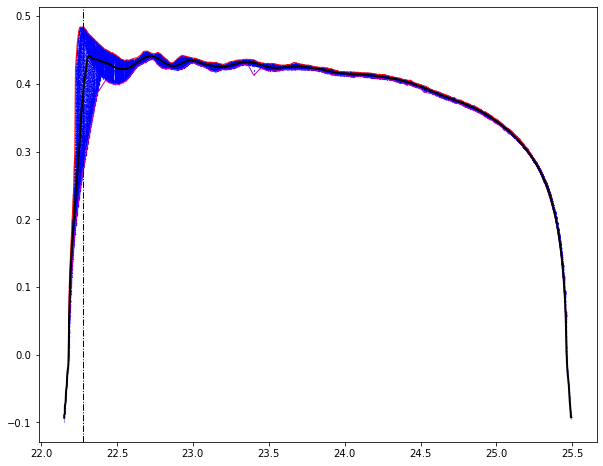

In [2]:

path = '/home/e.sharaborin/Dropbox/Oleg-Evgenii/dumps/'
fn = 'r_over_x_total_t=16.1542.csv'
# fn = 'r_over_x_total_t=11.9414.csv'
# fn = 'r_over_x_total_t=9.989.csv'
with open(path + fn, 'r') as f:
    lists = json.load(f)
    x, y = np.array(lists[0]), np.array(lists[1])
xcm = 18.7
xz = plot_smoothed_curve(x, y, alpha=0.05, Npolyfit=50, plot_clusters=False, plot_all_points=True, plot_min_max_curves=True, plot_smooth_curve=True, plot_rhomb=False, show_cluster_num=False, show_split_line=False)

In [3]:
lower_hull, upper_hull, XX, YY, x_peak, y_peak, length_x_clip, delta_min, delta_max, delta_min_smooth, delta_max_smooth, xy0, xyN = find_smooth_curve_and_bounds(x, y, alpha = 0.1, M = 3, convolution = False, chebushev = True, Ninterp = 4000, Npolyfit = 50, window = 100, is_cycle = False)

xy0= (22.182716369628906, 0.0004700725034859927) xyN= (25.459623336791992, 0.005237827916105199) length= 3.276906967163086
Cluster 0 contains 48316 points within             -0.23<x<0.44 & -0.15<y<0.28,             ratio = 1.59
Chebushev is done xminmax=-0.23441147830455183 0.4426976423367335
Cluster 1 contains 190662 points within             -1.1<x<1.2 & -0.049<y<0.16,             ratio = 11.6
Chebushev is done xminmax=-1.1182401317063357 1.2451723043209348
Cluster 2 contains 79983 points within             -0.57<x<0.69 & -0.032<y<0.31,             ratio = 3.62
Chebushev is done xminmax=-0.5654358915355416 0.685231742541699
min_x_ind=505 max_x_ind=88
max =22.277782440185547 0.48439719147925225
sizes of ripple:(186,) (186,)
peaks, props: [ 38  75  83  95 136 169] {'prominences': array([0.05946762, 0.01322222, 0.0018775 , 0.00857939, 0.00757122,
       0.00410576]), 'left_bases': array([  0,  65,  80,  90, 122, 163]), 'right_bases': array([185, 185, 185, 185, 185, 185])}
x_peak candida

In [22]:
plot_graph([XX], [YY], \
		   [ "smoothed", 'first peak', 'center of mass'], \
		   list_x_fill=[lower_hull[:,0], upper_hull[:,0]], list_y_fill=[lower_hull[:,1], upper_hull[:,1]], \
		   dash=['solid', 'solid', 'dot', 'dot'], \
		   xtitle="x", ytitle="r", image_name=fn[:-3]+'pdf', mode=['markers', 'lines+markers', 'lines', 'lines'], \
		   colors=['blue', 'red', 'black', 'black' ], yrange=[0,0.5], xrange=[xy0[0] - 0.1, xyN[0] + 0.1],\
		   marker_size=1, width=1000, height=500, path='./')

Plot curve number: 0
Write image to file: ./r_over_x_total_t=16.1542.pdf
Successfully generated: ./r_over_x_total_t=16.1542.pdf


In [5]:
# !pip install -U kaleido

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=[1, 2, 3, 4], y=[0, 2, 3, 5], fill='tozeroy')) # fill down to xaxis
# fig.add_trace(go.Scatter(x=[1, 2, 3, 4], y=[3, 5, 1, 7], fill='tonexty')) # fill to trace0 y

# fig.show()
# def smooth_sort_in_mini_square(x, y, dx=0.01, dy=0.01):
# 	aa = np.c_[x,y]
# 	xmin = x.min()
# 	xmax = x.max()
# 	x_cm = 0.5*(xmin + xmax)

# 	#find initial point
# 	first_part  = aa[(y <  0.35) & (x <  x_cm)]
# 	first_part = sort_by_theta(first_part, x_cm, shift=True) # sort by theta
# 	x0, y0 = first_part[0]
# 	print('Starting point:', x0, y0)
# 	print('MinMax point X:', xmin, xmax)

# 	xx, yy, x0_list = [], [], []
# 	x0k, y0k, k = x0, y0, 0
# 	x0_list.append(x0k)
# 	def find_next_box(x, y, x0k, y0k, dx, dy, i, j):
# 		ind = (x0k - (0.5 + i)*dx <= x) & (x <= x0k + (0.5 + i)*dx) & (y0k - (0.5 + j)*dy <= y) & (y <= y0k + (0.5 + j)*dy)
# 		xk = x[ind].mean()
# 		yk = y[ind].mean()
# 		return xk, yk, x[ind].size

# 	while (1):
# 		ind = (x0k - 0.5*dx <= x) & (x <= x0k + 0.5*dx) & (y0k - 0.5*dy <= y) & (y <= y0k + 0.5*dy)
# 		xk, yk, num = find_next_box(x, y, x0k, y0k, dx, dy, 0, 0)
# 		xx.append(xk)
# 		yy.append(yk)
# 		k += 1
# 		for i in [-1, 0 , 1]:
# 			for j in [-1, 0, 1]:
# 				x0k, y0k, n0k = find_next_box(x, y, x0k, y0k, dx, dy, i, j)

# 	# jump = np.sqrt(np.diff(sorted_points[:,0])**2 + np.diff(sorted_points[:,1])**2)
# 	# sorted_points = sorted_points[:-1]
# 	# smooth_jump = gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
# 	# limit = 5*np.median(smooth_jump)    # factor 2 is arbitrary
# 	# sorted_points = sorted_points[(jump > 0) & (smooth_jump < limit)]
# 	# sorted_points = sorted_points[jump>0]

# 	return np.asarray(xx), np.asarray(yy), x0, xmin, xmax

In [14]:
import plotly.graph_objects as go
xs = np.arange(0,4*np.pi, 0.1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=(10)*np.sin(xs), fill='tozeroy'))
fig.add_trace(go.Scatter(x=xs, y=np.sin(xs), fill='tozeroy'))

# fig.add_scatter(x=xs[[0,-1]], y=[11,11], fill='tonexty')
fig.layout = dict(xaxis=dict(linecolor='black', mirror=True),
                  yaxis=dict(zeroline=False, linecolor='black', mirror=True),
                  height=600, showlegend=False
                 )
fig